In [1]:
import sys
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
import chaospy

# 1d Gaussian likelihood and prior test for nfmc_jax

In [2]:
def log_like(x, mu=jnp.array([0]), cov=jnp.array([[1.0]])):
    return mvn.logpdf(x, mu, cov)

def log_prior(x, mu=jnp.array([0]), cov=jnp.array([[25.0]])):
    return mvn.logpdf(x, mu, cov)

key = jax.random.PRNGKey(100)
prior_samples = jax.random.multivariate_normal(key, mean=jnp.array([0.0]), 
                                               cov=jnp.array([[25.0]]), shape=(50,))
prior_samples.shape[1]

1

In [3]:
trace = nfmc_jax.infer_nfomc(log_like, log_prior, prior_samples, 
                             log_like_args=(jnp.array([0]), jnp.array([[1.0]])), 
                             log_prior_args=(jnp.array([0]), jnp.array([[25.0]])), 
                             vmap=True, parallel_backend=None, n0=100, iteration=5, 
                             N_AF=1000, expl_top_AF=40, expl_latent=5, expl_top_qw=5, local_thresh=3,
                             nfmc_draws=100, nf_iter=10, k_trunc=np.inf, ess_tol=0.9, eps_z=0.05,
                             inference_mode="sampling", cull_lowp_tol=0.01, max_cull_frac=0.0,
                             trainable_qw=False, beta_max=1)

Inference mode is sampling. Maximum beta is set to 1.


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:339: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  self.nf_model = GIS(torch.from_numpy(np.asarray(self.samples)),
/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:494: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/cond

logIW3 [-0.5386758   0.72056603 -0.29298925  0.90451956 -0.56630325  3.3180456
 -0.6114149  -0.39761305  3.6077733  -0.06256223 -0.24826288  0.59862304
 -0.5844908   0.18166637 -0.34773993  3.0577297  -0.15374517  0.70477915
 -0.38059163 -0.61782503 -0.52229095 -0.62065387 -0.37730074  1.7361677
 -0.4920714   2.5823207   1.7718122   2.0712366   2.6021702   0.31629372
 -0.32776952 -0.44073367  4.7387886   0.34803438 -0.4174595   1.1555755
  0.18260098 -0.17241693  0.2786777  -0.6167232   0.2372241   0.29435253
 -0.6068399  -0.06687117 -0.61294484  1.1593702   4.830278   -0.10151958
  0.6576469   0.35984516]
self.beta before iteration 0
beta:  1.0
ESS:  11
beta:  0.5
ESS:  16
beta:  0.25
ESS:  25
self beta 0.25
logIW3 [-3.40622663e-01 -1.56365919e+00 -1.97297144e+00 -5.30185890e+00
 -7.93006420e-02 -1.08962746e+01  4.95831966e-01 -1.68824434e+00
 -1.13982830e+01 -3.02617502e+00 -1.14002478e+00 -1.13599396e+00
  9.09794569e-01 -3.84385538e+00 -2.95976210e+00 -1.00138445e+01
  2.60686874e-

qw weighted mean = -0.05075856298208237
qw weighted sd = 0.9758097529411316
sigma_prod = 0.9805806875228882
quw weighted mean = 0.10925900936126709
quw weighted sd = 1.0264863967895508


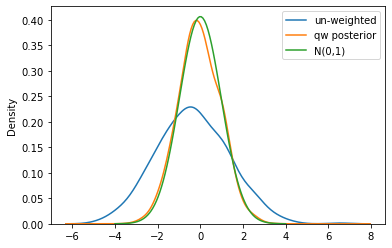

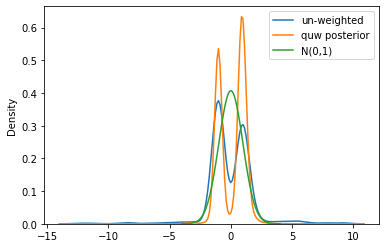

In [4]:
posterior = trace['qw_posterior'][0]
betas = trace['betas']

x = np.asarray(posterior).squeeze()
w = np.clip(trace['qw_posterior_weights'][0], a_min=0, a_max=None)

qw_mu = jnp.average(x, weights=w)
qw_sd = jnp.sqrt(jnp.average((x - qw_mu) ** 2, weights=w))

print(f'qw weighted mean = {qw_mu}')
print(f'qw weighted sd = {qw_sd}')

sigma_prod = jnp.sqrt((5.0 ** 2) / (5.0 ** 2 + 1.0 ** 2))
print(f'sigma_prod = {sigma_prod}')
def gauss(z, mu=0, cov=jnp.array([[sigma_prod ** 2]])):
    return jax.vmap(lambda x: jnp.exp(mvn.logpdf(x, mu, cov)))(z).squeeze()

z = jnp.linspace(-4, 4, 100)
plt.figure()
sns.kdeplot(x, label='un-weighted')
sns.kdeplot(x, weights=w, label='qw posterior')
plt.plot(z, gauss(z), label='N(0,1)')
plt.legend(loc='upper right')

posterior = trace['quw_posterior'][0]

x = np.asarray(posterior).squeeze()
w = np.clip(trace['quw_posterior_weights'][0], a_min=0, a_max=None)

quw_mu = jnp.average(x, weights=w)
quw_sd = jnp.sqrt(jnp.average((x - quw_mu) ** 2, weights=w))

print(f'quw weighted mean = {quw_mu}')
print(f'quw weighted sd = {quw_sd}')

z = np.linspace(-4, 4, 100)
plt.figure()
sns.kdeplot(x, label='un-weighted')
sns.kdeplot(x, weights=w, label='quw posterior')
plt.plot(z, gauss(z), label='N(0,1)')
plt.legend(loc='upper right')

dict_keys(['q1_w', 'q1_uw', 'q2_w', 'q2_uw', 'q3_w', 'q3_uw', 'q_nfmc_1_w', 'q_nfmc_1_uw', 'q_nfmc_2_w', 'q_nfmc_2_uw', 'q_nfmc_3_w', 'q_nfmc_3_uw', 'q_nfmc_4_w', 'q_nfmc_4_uw', 'q_nfmc_5_w', 'q_nfmc_5_uw'])
dict_keys(['q1_w', 'q1_uw', 'q2_w', 'q2_uw', 'q3_w', 'q3_uw', 'q_nfmc_1_w', 'q_nfmc_1_uw', 'q_nfmc_2_w', 'q_nfmc_2_uw', 'q_nfmc_3_w', 'q_nfmc_3_uw', 'q_nfmc_4_w', 'q_nfmc_4_uw', 'q_nfmc_5_w', 'q_nfmc_5_uw'])


<AxesSubplot:ylabel='Density'>

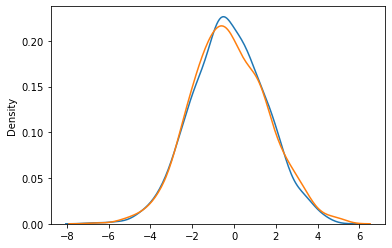

In [5]:
q_models = trace['q_models'][0]
print(q_models.keys())
q1 = q_models['q1_w'][0]
import torch
q1_samples, _ = q1.sample(1000, device='cpu') 
q1_samples = q1_samples.numpy()

sns.kdeplot(q1_samples.squeeze())

q_models = trace['q_models'][0]
print(q_models.keys())
q2 = q_models['q_nfmc_1_w'][0]
import torch
q2_samples, _ = q2.sample(1000, device='cpu') 
q2_samples = q2_samples.numpy()

sns.kdeplot(q2_samples.squeeze())

# Correlated Gaussian test

In [4]:
n = 10

np.random.seed(10)
key = jax.random.PRNGKey(10)
# Draw precision matrix from the Wishart distribution, with n degrees of freedom and identity scale.
wish = scipy.stats.wishart(df=n, scale=np.eye(n))
A = wish.rvs()
detA = jnp.linalg.det(A)

mu = jnp.ones(n)

prior_samples = jax.random.uniform(key, shape=(500, n), minval=-10, maxval=10)

def log_like(x, mu=mu, cov=jnp.linalg.inv(A)):
    return mvn.logpdf(x, mu, cov)

def log_prior(x, loc=-10, scale=20):
    return jnp.sum(jax.scipy.stats.uniform.logpdf(x, loc, scale))

lower = -10 * jnp.ones(n)
upper = 10 * jnp.ones(n)
bounds = jnp.array([lower, upper])
print(bounds)

[[-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.]]


In [8]:
trace = nfmc_jax.infer_nfomc(log_like, log_prior, prior_samples, 
                             log_like_args=(mu, jnp.linalg.inv(A)), 
                             log_prior_args=(-10, 20), 
                             bounds=bounds,
                             vmap=True, parallel_backend=None, n0=500, iteration=5, 
                             N_AF=1000, expl_top_AF=50, expl_latent=10, expl_top_qw=10, local_thresh=3,
                             nfmc_draws=100, nf_iter=10, k_trunc=0.5, ess_tol=0.9, eps_z=0.05,
                             inference_mode="sampling", cull_lowp_tol=0.01, max_cull_frac=0.1,
                             trainable_qw=False, beta_max=1, N_temp=1000)

Inference mode is sampling. Maximum beta is set to 1.
logIW3 [-1.777813    0.3209839  -0.45539856 -1.3036537  -2.1059856  -1.2892303
 -2.929411   -2.045166   -1.2644958  -1.0980606  -1.0143986  -0.25667572
  0.3743248  -0.3720684  -0.6212654   0.42388153 -0.22836685 -2.8453484
 -0.1619091  -1.8558388  -0.12761688 -1.4752274  -0.14740753 -3.6486244
 -0.4399624   0.13931465 -0.7666302   0.8557396  -1.5201435  -2.7772026
  2.0231838  -0.17556381 -1.3030491  -1.0565224  -1.8920708  -1.7770004
 -0.48890305 -0.8994179  -0.33973312 -0.30091858 -0.11487579 -0.18126106
  0.33006668  0.22127533 -1.4751587   0.6289196   0.05739975 -0.8293171
 -0.43622017 -0.68224335  0.919405   -0.14626503 -2.890131   -3.6574326
 -1.1522331  -1.9701042  -0.690609   -0.15964508 -0.36717987 -1.3793755
 -0.27820778 -0.49551964 -0.791481    0.17810059 -0.38054657 -1.0365448
 -0.66509247  0.65903664 -4.87224     0.04638672 -1.4310303   0.15172386
 -0.79234695 -0.24446869 -0.6444359  -1.0826721  -3.0753307  -0.7412586


jnp.shape(nfomc.posterior_logp) = (550,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-2.2573242e+00 -1.8321075e+00 -3.2193222e+00 -1.4164505e+00
 -1.4610214e+00 -8.7639618e-01 -4.5296402e+00 -1.7219315e+00
 -1.8982525e+00 -3.5005951e-01 -9.3777084e-01 -4.7130966e-01
 -8.9613342e-01 -2.7129936e+00 -1.9206619e-01 -1.9667053e+00
 -1.8908691e-01 -4.6691990e+00 -2.3104782e+00 -1.3890743e+00
 -1.5986080e+00 -1.0798359e+00 -9.0495872e-01 -2.2640915e+00
 -2.0766544e+00 -8.3773994e-01 -1.6436005e+00 -1.7542324e+00
 -2.2349281e+00 -2.7273731e+00 -7.4208069e-01 -4.6187592e-01
 -2.9031906e+00 -2.5332088e+00 -2.3233795e+00 -1.7282009e+00
 -2.7880669e-01 -1.8005638e+00 -1.0612469e+00  1.1087036e-01
 -7.1134186e-01  5.0342751e-01 -1.3936615e+00 -1.8348217e+00
 -1.5500546e+00 -8.1740570e-01 -2.2546921e+00 -3.1059361e+00
 -9.2908096e-01 -6.8771172e-01 -1.2081032e+00 -8.2026672e-01
 -3.5376968e+00 -2.5273895e+00 -1.3714275e+00 -3.3842754e+00
 -1.2124290e+00 -1.6546707e+00 -9.8766899e-0

jnp.shape(nfomc.posterior_logp) = (600,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-3.461914   -1.5752659  -2.668003   -1.5433788  -1.2973995  -3.022398
 -3.7210655  -1.0920582  -1.5257511  -1.2435455  -1.7691154  -1.4914532
 -0.31672478 -3.025486   -0.35886192 -2.0733452  -0.965168   -4.2027607
 -1.5122452  -2.1491127  -2.6491165  -2.592476   -1.1533203  -2.2075348
 -1.9002914  -1.2991009  -1.7103786  -2.382372   -1.7226162  -3.9547424
 -1.63661    -1.4523258  -3.6220589  -2.7759132  -3.2320251  -1.2996521
 -0.5254631  -1.0852547  -1.7825089   0.2573471  -1.7090855  -1.3325691
 -1.8907223  -1.9264584  -1.7926655  -0.7699261  -1.6985512  -3.5406265
 -0.9113617  -1.7351036  -1.563118   -0.9136715  -2.6529236  -2.8579254
 -2.946684   -3.84099    -0.94865036 -2.4118938  -0.91241074 -3.552534
 -0.56090546 -2.6533012  -0.14176178 -0.7612381  -0.71861076 -0.94462967
 -2.217579   -1.0202389  -5.1368713  -1.3242741  -1.5514088  -2.0678272
 -0.892725   -2.0713806  -2.6397705

jnp.shape(nfomc.posterior_logp) = (650,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-4.114338   -3.0028915  -3.8632088  -1.7924843  -1.5891647  -2.0584373
 -6.5078335  -2.596157   -2.461666   -1.3727951  -3.4655304  -2.5328217
 -1.6553822  -2.5050468  -1.7335453  -3.9683628  -1.6247597  -4.9307213
 -2.080801   -3.7470741  -3.478613   -2.0205574  -2.8832397  -2.95368
 -4.5139084  -1.1964493  -2.2817345  -2.5985622  -2.296032   -4.2479286
 -1.3900223  -1.7217274  -5.224247   -3.826727   -4.143051   -2.9665623
 -1.1618996  -2.5692291  -1.8531208  -1.3372593  -2.8914013  -1.7522354
 -1.8045101  -2.667122   -2.5981293  -1.7483139  -2.5071564  -4.829502
 -1.7347736  -1.1419468  -2.5048141  -1.3352013  -3.6946068  -3.878111
 -3.2375774  -2.7753372  -3.0154266  -3.1947975  -2.42655    -4.8695545
 -1.5904503  -4.4973183  -0.7213421  -1.7366486  -1.8942757  -2.523325
 -4.9484596  -1.8772202  -6.9664726  -0.7555618  -3.2141724  -3.1376457
 -1.4085293  -4.287733   -3.9641838  -6

jnp.shape(nfomc.posterior_logp) = (700,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-3.9826431  -3.321455   -5.5217705  -2.3218555  -1.2201958  -2.824215
 -6.4332275  -1.680582   -1.9033127  -1.7794037  -2.703682   -2.8366165
 -2.3926373  -4.394867   -1.0728035  -4.166687   -2.3768578  -4.661064
 -2.1754723  -3.9903278  -3.4483051  -1.9205055  -2.9828224  -3.2982502
 -3.9779701  -2.5825768  -2.20397    -3.6012592  -2.1227417  -4.953924
 -2.1710644  -1.6092834  -5.8361473  -5.1520405  -4.3914394  -2.7175255
 -2.7665005  -1.2241402  -1.8969898  -1.5130653  -3.8325863  -3.7944393
 -3.504116   -3.0673485  -2.72258    -1.7019329  -2.5291367  -5.9928284
 -1.9313431  -1.7471447  -3.352131   -2.283699   -3.811493   -2.996481
 -3.4845142  -3.9642239  -3.706976   -4.0418625  -2.3744526  -4.9037285
 -3.751997   -5.398262   -0.6025486  -2.2663937  -1.3626766  -2.3055267
 -5.8504677  -2.3652306  -8.451649   -1.2690792  -2.4589405  -3.3566093
 -1.5201416  -2.9993     -4.239334   -

jnp.shape(nfomc.posterior_logp) = (750,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-5.6246986e+00 -3.4870319e+00 -5.0504112e+00 -2.9429626e+00
 -3.8118134e+00 -6.0701904e+00 -9.2669277e+00 -3.0427837e+00
 -3.7493038e+00 -2.8254929e+00 -4.2346191e+00 -4.1144600e+00
 -3.1807823e+00 -4.6298504e+00 -1.3407593e+00 -6.5126305e+00
 -2.6720047e+00 -5.3016052e+00 -3.2870216e+00 -5.2972946e+00
 -4.9572563e+00 -2.6805496e+00 -3.0625896e+00 -5.2454720e+00
 -5.0352650e+00 -3.2644768e+00 -3.0909653e+00 -4.6456451e+00
 -4.4189034e+00 -5.2898827e+00 -3.2624702e+00 -1.0943184e+00
 -6.6439781e+00 -5.0901585e+00 -5.7145386e+00 -3.6900826e+00
 -2.6236725e+00 -1.8507347e+00 -1.8092327e+00 -2.1609821e+00
 -4.5400581e+00 -3.3782501e+00 -4.3901672e+00 -3.2967701e+00
 -2.5604439e+00 -1.3340855e+00 -2.8965492e+00 -6.5679207e+00
 -2.8512230e+00 -3.2194519e+00 -5.5866203e+00 -3.6487007e+00
 -4.5193901e+00 -6.2372742e+00 -5.3649616e+00 -4.0547333e+00
 -5.1542435e+00 -5.6793423e+00 -4.0088520e+0

jnp.shape(nfomc.posterior_logp) = (800,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [ -5.647499    -4.127865    -6.19685     -2.3747902   -4.650923
  -4.8023357   -8.691753    -3.0144901   -2.4882793   -2.1533813
  -4.268816    -4.6670723   -1.8560543   -4.513199    -2.9038277
  -5.9951687   -2.104721    -5.7331657   -4.363796    -5.597431
  -4.2959785   -2.8228016   -2.7959805   -4.9875336   -4.601879
  -3.5879211   -2.1057281   -4.392725    -3.3185005   -7.5110035
  -1.6418209   -0.8013363   -6.4076767   -6.699642    -4.2683907
  -4.1988506   -2.8986816   -1.3670235   -4.343363    -1.4549828
  -4.8385963   -1.6490555   -3.9554214   -3.2732544   -3.617916
  -2.3546162   -4.1718464   -6.7944183   -3.0865135   -3.0522003
  -4.8289833   -2.485546    -5.9643784   -6.1923943   -4.793499
  -3.3598099   -4.5929546   -5.474701    -3.3083954   -5.382004
  -1.835392    -6.8365173   -1.003521    -3.5869675   -3.586544
  -2.8025074   -7.080963    -1.6443405  -12.077492    -1.075

jnp.shape(nfomc.posterior_logp) = (850,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [ -5.7000313   -5.4491463   -7.8054237   -3.0870056   -3.5257092
  -5.9855194  -10.439167    -3.265705    -2.1870193   -2.5084133
  -4.8047447   -5.7852345   -2.9494343   -5.0795937   -3.2022495
  -6.3443832   -2.9510345   -7.141857    -3.8358784   -6.4806824
  -5.3770866   -1.5363445   -3.6340027   -5.148365    -5.9210243
  -3.534748    -2.7630844   -5.1739044   -3.894909    -8.626707
  -3.3063622   -0.6652069   -8.489536    -6.75309     -5.3525505
  -4.695347    -3.2285995   -2.718727    -3.8408089   -2.1707897
  -5.8580704   -2.967205    -4.4498367   -4.484913    -3.3139668
  -2.55579     -4.3967934   -8.173954    -4.0043144   -2.9341278
  -5.8208237   -2.8420944   -5.770239    -5.5360126   -5.5642433
  -4.6534805   -4.154148    -4.8627625   -4.428011    -6.965517
  -2.8169594   -7.5770035   -1.447979    -4.571642    -4.025755
  -3.8954468   -9.276619    -3.1271038  -13.094595    -2

jnp.shape(nfomc.posterior_logp) = (900,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [ -5.257593    -5.265896    -7.846615    -2.5925941   -3.202589
  -5.9904137   -9.796036    -3.9719849   -2.8712826   -3.1715202
  -6.145199    -5.931278    -3.3965836   -5.478199    -3.45825
  -6.458641    -3.7556686   -6.6594296   -5.216421    -5.9337196
  -5.863579    -2.352087    -4.188072    -4.7502213   -7.023426
  -4.2412186   -3.6291542   -4.9307213   -4.5068245   -8.764523
  -2.6545029   -1.456274    -8.644552    -7.2514763   -6.3637695
  -4.5461464   -3.9090004   -2.1603317   -3.914688    -2.2922497
  -5.8793774   -1.7687187   -4.932232    -3.2376041   -3.7148247
  -2.9280605   -4.1961327   -9.002277    -3.885765    -2.869793
  -6.5205307   -3.4753323   -6.5711746   -5.68145     -6.3003387
  -4.614044    -5.7371864   -5.7317333   -4.123291    -6.957409
  -2.9016018   -8.742455    -2.266014    -5.148327    -3.3107224
  -3.9600334   -9.247166    -2.687622   -13.946474    -2.079

jnp.shape(nfomc.posterior_logp) = (950,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [ -6.1225624   -4.885296    -8.470623    -4.008915    -3.3448887
  -5.4212933   -9.184917    -3.837597    -2.9960594   -2.9528847
  -5.140089    -5.6702595   -2.2784424   -5.5442657   -2.997116
  -7.4637966   -2.5874443   -7.593115    -4.8719597   -6.7866383
  -6.451       -2.6554985   -3.7498493   -2.7553692   -5.6488
  -3.0360394   -3.1934013   -5.0634594   -4.6981926   -9.06889
  -3.2456665   -1.5588665   -8.306852    -8.199127    -5.1310196
  -4.808092    -3.74366     -2.4233685   -3.7602596   -2.046648
  -5.7359715   -5.105179    -4.4325066   -3.301712    -4.4474487
  -2.8393383   -5.5031395   -8.965183    -2.7850914   -3.1357021
  -5.784603    -3.5899487   -4.9404335   -5.4418297   -6.335306
  -4.0735493   -5.298111    -5.251457    -4.1395836   -6.6490746
  -1.7265396   -9.117628    -2.2426262   -4.8667088   -4.144882
  -3.3488045   -8.459974    -2.8467388  -13.685848    -3.44644

jnp.shape(nfomc.posterior_logp) = (1000,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [ -7.9568176  -6.2233086 -10.237316  ...  -3.7281208  -3.3184261
  -4.5719376]
self.beta before iteration 0.0037764177442214924
beta:  1.0018882088721108
ESS:  1
beta:  0.5028323133081661
ESS:  1
beta:  0.2533043655261938
ESS:  1
beta:  0.12854039163520764
ESS:  1
beta:  0.06615840468971457
ESS:  1
beta:  0.03496741121696803
ESS:  3
beta:  0.019371914480594762
ESS:  16
beta:  0.011574166112408128
ESS:  42
beta:  0.00767529192831481
ESS:  91
beta:  0.005725854836268151
ESS:  151
beta:  0.004751136290244822
ESS:  203
beta:  0.0042637770172331575
ESS:  238
beta:  0.004020097380727325
ESS:  258
beta:  0.004141937198980241
ESS:  247
beta:  0.004081017289853783
ESS:  252
beta:  0.0041114772444170115
ESS:  250
self beta 0.0041114772444170115
jnp.shape(nfomc.posterior_logp) = (1050,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-8.149906  -6.4532127 -9.793844  ... -3.3258095 

jnp.shape(nfomc.posterior_logp) = (1500,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-17.175436  -11.948166  -21.237053  ...  -5.3480644  -3.825262
  -5.0995064]
self.beta before iteration 0.007978182436263947
beta:  1.003989091218132
ESS:  1
beta:  0.5059836368271979
ESS:  1
beta:  0.2569809096317309
ESS:  2
beta:  0.13247954603399745
ESS:  2
beta:  0.0702288642351307
ESS:  4
beta:  0.03910352333569732
ESS:  17
beta:  0.023540852885980634
ESS:  53
beta:  0.01575951766112229
ESS:  102
beta:  0.01186885004869312
ESS:  157
beta:  0.009923516242478534
ESS:  207
beta:  0.00895084933937124
ESS:  243
beta:  0.008464515887817593
ESS:  264
beta:  0.008707682613594416
ESS:  253
beta:  0.008829265976482828
ESS:  248
beta:  0.008768474295038622
ESS:  250
self beta 0.008768474295038622
jnp.shape(nfomc.posterior_logp) = (1550,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-19.502134  -12.117926  -22.624401  ...  -5.1465645  -5.0737114
  -5.668602 ]
self.beta befo

jnp.shape(nfomc.posterior_logp) = (2000,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-25.891598 -16.961296 -31.107786 ...  -5.082609  -6.19083   -8.986362]
self.beta before iteration 0.011973754644484216
beta:  1.005986877322242
ESS:  2
beta:  0.5089803159833631
ESS:  2
beta:  0.2604770353139237
ESS:  2
beta:  0.13622539497920394
ESS:  3
beta:  0.07409957481184408
ESS:  6
beta:  0.04303666472816415
ESS:  28
beta:  0.02750520968632418
ESS:  82
beta:  0.0197394821654042
ESS:  135
beta:  0.015856618404944206
ESS:  181
beta:  0.01391518652471421
ESS:  214
beta:  0.012944470584599212
ESS:  236
beta:  0.012459112614541714
ESS:  248
beta:  0.012216433629512965
ESS:  255
beta:  0.01233777312202734
ESS:  251
beta:  0.012398442868284527
ESS:  250
self beta 0.012398442868284527
jnp.shape(nfomc.posterior_logp) = (2050,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-26.588287  -17.73362   -30.636723  ...  -4.851921   -5.7490234
  -7.8423615]
self.beta before iter

jnp.shape(nfomc.posterior_logp) = (2500,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-41.24344  -25.584724 -48.169037 ... -10.018583 -10.839176  -9.841389]
self.beta before iteration 0.01842709950834403
beta:  1.009213549754172
ESS:  1
beta:  0.513820324631258
ESS:  1
beta:  0.266123712069801
ESS:  1
beta:  0.14227540578907252
ESS:  5
beta:  0.08035125264870828
ESS:  11
beta:  0.04938917607852615
ESS:  24
beta:  0.033908137793435086
ESS:  57
beta:  0.026167618650889558
ESS:  109
beta:  0.022297359079616795
ESS:  160
beta:  0.020362229293980412
ESS:  198
beta:  0.01939466440116222
ESS:  220
beta:  0.018910881954753125
ESS:  232
beta:  0.018668990731548575
ESS:  239
beta:  0.018548045119946302
ESS:  242
beta:  0.018487572314145165
ESS:  244
beta:  0.0184573359112446
ESS:  244
beta:  0.018442217709794314
ESS:  245
beta:  0.01843465860906917
ESS:  245
beta:  0.0184308790587066
ESS:  245
beta:  0.018428989283525314
ESS:  245
beta:  0.01842804439593467
ESS:  245
self beta 

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (2950,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-50.601387 -30.655777 -59.289238 ...  -9.06041  -10.6576   -13.699509]
self.beta before iteration 0.022477225466593323
beta:  1.0112386127332966
ESS:  1
beta:  0.5168579190999449
ESS:  2
beta:  0.26966757228326915
ESS:  3
beta:  0.14607239887493123
ESS:  6
beta:  0.08427481217076227
ESS:  14
beta:  0.053376018818677796
ESS:  34
beta:  0.03792662214263556
ESS:  76
beta:  0.030201923804614443
ESS:  131
beta:  0.026339574635603883
ESS:  179
beta:  0.0244084000510986
ESS:  212
beta:  0.023442812758845962
ESS:  231
beta:  0.022960019112719644
ESS:  241
beta:  0.022718622289656484
ESS:  246
beta:  0.022597923878124905
ESS:  249
beta:  0.022537574672359114
ESS:  250
self beta 0.022537574672359114
jnp.shape(nfomc.posterior_logp) = (3000,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-51.00152  -30.556091 -58.539383 ...  -8.165272  -5.485426 -10.771002]
self.beta before itera

jnp.shape(nfomc.posterior_logp) = (3400,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-60.28945   -36.379623  -68.28891   ...  -6.5898857  -8.540596
 -23.283981 ]
self.beta before iteration 0.026492671652493846
beta:  1.013246335826247
ESS:  1
beta:  0.5198695037393704
ESS:  2
beta:  0.2731810876959321
ESS:  3
beta:  0.14983687967421297
ESS:  7
beta:  0.0881647756633534
ESS:  17
beta:  0.05732872365792362
ESS:  41
beta:  0.04191069765520873
ESS:  87
beta:  0.03420168465385129
ESS:  141
beta:  0.030347178153172567
ESS:  184
beta:  0.028419924902833207
ESS:  211
beta:  0.027456298277663528
ESS:  226
beta:  0.026974484965078687
ESS:  234
beta:  0.02673357830878627
ESS:  238
beta:  0.026613124980640057
ESS:  241
beta:  0.02655289831656695
ESS:  242
beta:  0.0265227849845304
ESS:  242
beta:  0.02650772831851212
ESS:  242
beta:  0.026500199985502983
ESS:  243
beta:  0.026496435818998416
ESS:  243
beta:  0.02649455373574613
ESS:  243
beta:  0.02649361269411999
ESS:  243
self

jnp.shape(nfomc.posterior_logp) = (3850,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-71.04321   -43.819294  -83.002625  ...  -6.3117104  -7.059883
 -22.096975 ]
self.beta before iteration 0.03155319968257429
beta:  1.015776599841287
ESS:  1
beta:  0.5236648997619306
ESS:  1
beta:  0.2776090497222525
ESS:  1
beta:  0.1545811247024134
ESS:  2
beta:  0.09306716219249384
ESS:  7
beta:  0.062310180937534064
ESS:  27
beta:  0.046931690310054175
ESS:  68
beta:  0.039242444996314234
ESS:  113
beta:  0.03539782233944426
ESS:  149
beta:  0.033475511011009276
ESS:  172
beta:  0.032514355346791785
ESS:  185
beta:  0.03203377751468304
ESS:  192
beta:  0.03179348859862867
ESS:  196
beta:  0.03167334414060148
ESS:  198
beta:  0.03161327191158789
ESS:  199
beta:  0.03158323579708109
ESS:  199
beta:  0.031568217739827695
ESS:  199
beta:  0.031560708711200994
ESS:  200
beta:  0.03155695419688764
ESS:  200
beta:  0.03155507693973097
ESS:  200
beta:  0.03155413831115263
ESS:  200
self 

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (4250,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-83.2611   -51.902473 -96.369125 ... -15.406887  -8.54229  -25.464622]
self.beta before iteration 0.03642012462882127
beta:  1.0182100623144106
ESS:  1
beta:  0.527315093471616
ESS:  1
beta:  0.2818676090502186
ESS:  2
beta:  0.15914386683951995
ESS:  7
beta:  0.09778199573417061
ESS:  24
beta:  0.06710106018149595
ESS:  68
beta:  0.05176059240515861
ESS:  119
beta:  0.04409035851698994
ESS:  152
beta:  0.04025524157290561
ESS:  170
beta:  0.03833768310086344
ESS:  180
beta:  0.037378903864842355
ESS:  186
beta:  0.03689951424683181
ESS:  188
beta:  0.03665981943782654
ESS:  190
beta:  0.0365399720333239
ESS:  191
beta:  0.03648004833107259
ESS:  191
beta:  0.03645008647994693
ESS:  191
beta:  0.036435105554384103
ESS:  191
beta:  0.03642761509160269
ESS:  191
beta:  0.03642386986021198
ESS:  191
beta:  0.03642199724451663
ESS:  191
beta:  0.03642106093666895
ESS:  191
self beta 0.03

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (4350,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-82.519264 -54.58571  -94.824295 ... -15.865074 -26.085096 -17.706367]
self.beta before iteration 0.036421997244070164
beta:  1.0182109986220351
ESS:  1
beta:  0.5273164979330527
ESS:  2
beta:  0.2818692475885614
ESS:  7
beta:  0.1591456224163158
ESS:  19
beta:  0.09778380983019298
ESS:  31
beta:  0.06710290353713158
ESS:  48
beta:  0.05176245039060087
ESS:  75
beta:  0.04409222381733552
ESS:  103
beta:  0.04025711053070284
ESS:  125
beta:  0.0383395538873865
ESS:  139
beta:  0.03738077556572833
ESS:  147
beta:  0.03690138640489925
ESS:  151
beta:  0.036661691824484706
ESS:  153
beta:  0.03654184453427743
ESS:  155
beta:  0.0364819208891738
ESS:  155
beta:  0.03645195906662198
ESS:  155
beta:  0.03643697815534607
ESS:  155
beta:  0.03642948769970812
ESS:  156
beta:  0.03642574247188914
ESS:  156
beta:  0.03642386985797966
ESS:  156
beta:  0.03642293355102491
ESS:  156
self beta 0.036

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (4400,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-83.62079   -52.28959   -93.11644   ...  -8.820885   -8.75959
  -6.6474495]
self.beta before iteration 0.03642293355102491
beta:  1.0182114667755124
ESS:  1
beta:  0.5273172001632687
ESS:  2
beta:  0.2818700668571468
ESS:  9
beta:  0.15914650020408583
ESS:  19
beta:  0.09778471687755537
ESS:  33
beta:  0.06710382521429015
ESS:  53
beta:  0.05176337938265753
ESS:  79
beta:  0.04409315646684122
ESS:  106
beta:  0.04025804500893307
ESS:  127
beta:  0.03834048927997899
ESS:  140
beta:  0.03738171141550195
ESS:  148
beta:  0.03690232248326343
ESS:  152
beta:  0.03666262801714417
ESS:  154
beta:  0.036542780784084544
ESS:  155
beta:  0.03648285716755473
ESS:  156
beta:  0.03645289535928982
ESS:  156
beta:  0.036437914455157365
ESS:  156
beta:  0.03643042400309114
ESS:  156
beta:  0.036426678777058026
ESS:  156
beta:  0.036424806164041465
ESS:  156
beta:  0.03642386985753319
ESS:  156
self 

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (4450,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-83.04408   -52.057632  -95.31378   ...  -6.9702454 -13.879595
 -33.440376 ]
self.beta before iteration 0.03642386985753319
beta:  1.0182119349287666
ESS:  1
beta:  0.5273179023931499
ESS:  3
beta:  0.28187088612534156
ESS:  11
beta:  0.15914737799143738
ESS:  29
beta:  0.09778562392448528
ESS:  61
beta:  0.06710474689100923
ESS:  107
beta:  0.051764308374271206
ESS:  153
beta:  0.044094089115902194
ESS:  183
beta:  0.040258979486717694
ESS:  201
beta:  0.03834142467212544
ESS:  211
beta:  0.037382647264829316
ESS:  217
beta:  0.03690325856118125
ESS:  219
beta:  0.03666356420935722
ESS:  221
beta:  0.03654371703344521
ESS:  221
beta:  0.0364837934454892
ESS:  222
beta:  0.0364538316515112
ESS:  222
beta:  0.03643885075452219
ESS:  222
beta:  0.036431360306027685
ESS:  222
beta:  0.03642761508178044
ESS:  222
beta:  0.03642574246965681
ESS:  222
beta:  0.036424806163595
ESS:  222
sel

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (4500,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-81.81759  -51.640305 -95.50523  ... -12.052376  -8.050131 -11.002747]
self.beta before iteration 0.036424806163595
beta:  1.0182124030817974
ESS:  1
beta:  0.5273186046226962
ESS:  1
beta:  0.2818717053931456
ESS:  8
beta:  0.1591482557783703
ESS:  30
beta:  0.09778653097098265
ESS:  64
beta:  0.06710566856728883
ESS:  115
beta:  0.05176523736544192
ESS:  179
beta:  0.04409502176451846
ESS:  237
beta:  0.04025991396405673
ESS:  277
beta:  0.042177467864287596
ESS:  256
beta:  0.04313624481440303
ESS:  246
beta:  0.04265685633934531
ESS:  251
beta:  0.042896550576874165
ESS:  249
beta:  0.04277670345810974
ESS:  250
self beta 0.04277670345810974


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (4550,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [ -97.803635   -62.72389   -113.98336   ...   -8.8204155  -17.342617
  -12.521545 ]
self.beta before iteration 0.04277670345810974
beta:  1.021388351729055
ESS:  1
beta:  0.5320825275935823
ESS:  1
beta:  0.287429615525846
ESS:  5
beta:  0.16510315949197787
ESS:  26
beta:  0.10393993147504381
ESS:  65
beta:  0.07335831746657677
ESS:  120
beta:  0.05806751046234325
ESS:  180
beta:  0.05042210696022649
ESS:  229
beta:  0.04659940520916811
ESS:  259
beta:  0.0485107560846973
ESS:  244
beta:  0.0475550806469327
ESS:  251
beta:  0.048032918365815
ESS:  247
beta:  0.04779399950637385
ESS:  249
beta:  0.047674540076653275
ESS:  250
self beta 0.047674540076653275


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (4600,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-108.30543   -68.993256 -127.06235  ...  -29.882906  -11.501457
  -22.556522]
self.beta before iteration 0.047674540076653275
beta:  1.0238372700383267
ESS:  1
beta:  0.5357559050574899
ESS:  2
beta:  0.2917152225670716
ESS:  8
beta:  0.16969488132186245
ESS:  25
beta:  0.10868471069925786
ESS:  63
beta:  0.07817962538795557
ESS:  119
beta:  0.06292708273230442
ESS:  175
beta:  0.055300811404478845
ESS:  216
beta:  0.05148767574056606
ESS:  241
beta:  0.04958110790860967
ESS:  254
beta:  0.05053439182458787
ESS:  247
beta:  0.05005774986659877
ESS:  250
self beta 0.05005774986659877


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (4650,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-115.62603   -73.026    -129.98679  ...  -18.863365  -34.97742
  -10.213469]
self.beta before iteration 0.05005774986659877
beta:  1.0250288749332994
ESS:  1
beta:  0.5375433123999491
ESS:  1
beta:  0.2938005311332739
ESS:  7
beta:  0.17192914049993635
ESS:  29
beta:  0.11099344518326756
ESS:  74
beta:  0.08052559752493317
ESS:  134
beta:  0.06529167369576597
ESS:  190
beta:  0.05767471178118237
ESS:  231
beta:  0.05386623082389057
ESS:  257
beta:  0.05577047130253647
ESS:  244
beta:  0.05481835106321352
ESS:  250
self beta 0.05481835106321352


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (4700,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-126.2081    -79.322975 -146.53094  ...  -29.794403  -38.1064
  -12.266129]
self.beta before iteration 0.05481835106321352
beta:  1.0274091755316068
ESS:  1
beta:  0.5411137632974101
ESS:  2
beta:  0.2979660571803118
ESS:  8
beta:  0.17639220412176268
ESS:  24
beta:  0.11560527759248809
ESS:  58
beta:  0.0852118143278508
ESS:  111
beta:  0.07001508269553217
ESS:  166
beta:  0.06241671687937284
ESS:  207
beta:  0.058617533971293184
ESS:  232
beta:  0.05671794251725335
ESS:  246
beta:  0.05576814679023344
ESS:  253
beta:  0.0562430446537434
ESS:  249
beta:  0.05600559572198842
ESS:  251
beta:  0.05612432018786591
ESS:  250
self beta 0.05612432018786591


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (4750,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-128.87688   -81.549255 -147.9916   ...   -9.654364   -9.936214
   -9.594822]
self.beta before iteration 0.05612432018786591
beta:  1.028062160093933
ESS:  1
beta:  0.5420932401408994
ESS:  2
beta:  0.2991087801643827
ESS:  11
beta:  0.1776165501761243
ESS:  35
beta:  0.11687043518199511
ESS:  80
beta:  0.08649737768493052
ESS:  136
beta:  0.07131084893639822
ESS:  186
beta:  0.06371758456213206
ESS:  221
beta:  0.05992095237499898
ESS:  242
beta:  0.05802263628143245
ESS:  253
beta:  0.05897179432821571
ESS:  247
beta:  0.05849721530482408
ESS:  250
self beta 0.05849721530482408


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (4800,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-133.36942   -85.56662  -156.68689  ...   -9.736778  -18.502632
  -20.902843]
self.beta before iteration 0.05849721530482408
beta:  1.029248607652412
ESS:  1
beta:  0.543872911478618
ESS:  2
beta:  0.3011850633917211
ESS:  9
beta:  0.1798411393482726
ESS:  30
beta:  0.11916917732654833
ESS:  71
beta:  0.0888331963156862
ESS:  129
beta:  0.07366520581025514
ESS:  182
beta:  0.06608121055753961
ESS:  219
beta:  0.06228921293118185
ESS:  241
beta:  0.06039321411800297
ESS:  253
beta:  0.06134121352459241
ESS:  247
beta:  0.060867213821297686
ESS:  250
self beta 0.060867213821297686


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (4850,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-141.30461   -89.40669  -163.46262  ...  -11.952587  -10.87151
  -10.413784]
self.beta before iteration 0.060867213821297686
beta:  1.0304336069106488
ESS:  1
beta:  0.5456504103659733
ESS:  2
beta:  0.3032588120936355
ESS:  10
beta:  0.18206301295746657
ESS:  30
beta:  0.12146511338938212
ESS:  68
beta:  0.09116616360533991
ESS:  122
beta:  0.07601668871331879
ESS:  170
beta:  0.06844195126730823
ESS:  203
beta:  0.06465458254430295
ESS:  222
beta:  0.06276089818280031
ESS:  232
beta:  0.061814056002049
ESS:  238
beta:  0.06134063491167334
ESS:  240
beta:  0.06110392436648551
ESS:  242
beta:  0.0609855690938916
ESS:  243
beta:  0.06092639145759464
ESS:  243
beta:  0.06089680263944616
ESS:  243
beta:  0.060882008230371924
ESS:  243
beta:  0.0608746110258348
ESS:  243
beta:  0.060870912423566244
ESS:  243
beta:  0.06086906312243197
ESS:  243
beta:  0.06086813847186483
ESS:  243
self b

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (4900,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-139.3329    -88.66681  -161.65799  ...   -9.744354  -12.53801
  -27.755215]
self.beta before iteration 0.06086813847186483
beta:  1.0304340692359324
ESS:  1
beta:  0.5456511038538986
ESS:  3
beta:  0.3032596211628817
ESS:  12
beta:  0.18206387981737326
ESS:  38
beta:  0.12146600914461905
ESS:  88
beta:  0.09116707380824193
ESS:  144
beta:  0.07601760614005337
ESS:  182
beta:  0.06844287230595911
ESS:  204
beta:  0.06465550538891196
ESS:  216
beta:  0.0627618219303884
ESS:  222
beta:  0.061814980201126614
ESS:  225
beta:  0.061341559336495724
ESS:  227
beta:  0.061104848904180276
ESS:  228
beta:  0.06098649368802255
ESS:  228
beta:  0.060927316079943686
ESS:  228
beta:  0.060897727275904256
ESS:  228
beta:  0.06088293287388454
ESS:  228
beta:  0.06087553567287468
ESS:  228
beta:  0.060871837072369754
ESS:  228
beta:  0.06086998777211729
ESS:  228
beta:  0.06086906312199106
ESS:  228


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (4950,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-140.15814   -88.71021  -160.56276  ...  -33.179672  -22.410744
  -14.445417]
self.beta before iteration 0.06086906312199106
beta:  1.0304345315609955
ESS:  2
beta:  0.5456517973414933
ESS:  3
beta:  0.30326043023174215
ESS:  10
beta:  0.18206474667686662
ESS:  34
beta:  0.12146690489942884
ESS:  85
beta:  0.09116798401070994
ESS:  149
beta:  0.0760185235663505
ESS:  195
beta:  0.06844379334417078
ESS:  222
beta:  0.06465642823308092
ESS:  237
beta:  0.06276274567753598
ESS:  245
beta:  0.06181590439976352
ESS:  249
beta:  0.06134248376087729
ESS:  251
beta:  0.06157919408032041
ESS:  250
self beta 0.06157919408032041


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (5000,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-141.27393   -90.81149  -162.50816  ...  -17.061035  -17.098305
  -30.585546]
self.beta before iteration 0.06157919408032041
beta:  1.0307895970401602
ESS:  2
beta:  0.5461843955602402
ESS:  4
beta:  0.3038817948202803
ESS:  13
beta:  0.18273049445030037
ESS:  39
beta:  0.1221548442653104
ESS:  90
beta:  0.0918670191728154
ESS:  153
beta:  0.0767231066265679
ESS:  195
beta:  0.06915115035344416
ESS:  210
beta:  0.06536517221688229
ESS:  214
beta:  0.06347218314860134
ESS:  215
beta:  0.06252568861446087
ESS:  215
beta:  0.06205244134739064
ESS:  215
beta:  0.061815817713855525
ESS:  215
beta:  0.061697505897087966
ESS:  215
beta:  0.06163834998870418
ESS:  215
beta:  0.061608772034512295
ESS:  215
beta:  0.061593983057416354
ESS:  215
beta:  0.06158658856886838
ESS:  215
beta:  0.061582891324594394
ESS:  215
beta:  0.0615810427024574
ESS:  215
beta:  0.061580118391388904
ESS:  215
se

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (5050,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-140.46521   -89.156685 -163.21738  ...  -10.900251  -32.61488
  -11.086462]
self.beta before iteration 0.061580118391388904
beta:  1.0307900591956944
ESS:  2
beta:  0.5461850887935417
ESS:  4
beta:  0.3038826035924653
ESS:  14
beta:  0.18273136099192708
ESS:  36
beta:  0.122155739691658
ESS:  80
beta:  0.09186792904152345
ESS:  137
beta:  0.07672402371645617
ESS:  176
beta:  0.06915207105392254
ESS:  195
beta:  0.06536609472265573
ESS:  205
beta:  0.06347310655702232
ESS:  210
beta:  0.06252661247420561
ESS:  212
beta:  0.062053365432797256
ESS:  213
beta:  0.061816741912093076
ESS:  214
beta:  0.06169843015174099
ESS:  214
beta:  0.061639274271564945
ESS:  214
beta:  0.06160969633147692
ESS:  215
beta:  0.061594907361432916
ESS:  215
beta:  0.06158751287641091
ESS:  215
beta:  0.061583815633899905
ESS:  215
beta:  0.0615819670126444
ESS:  215
beta:  0.061581042702016656
ESS:  215
s

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (5100,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-141.87076   -88.59972  -163.92915  ...  -15.309025  -33.56849
  -12.83078 ]
self.beta before iteration 0.061581042702016656
beta:  1.0307905213510082
ESS:  2
beta:  0.5461857820265125
ESS:  4
beta:  0.3038834123642646
ESS:  15
beta:  0.1827322275331406
ESS:  44
beta:  0.12215663511757863
ESS:  98
beta:  0.09186883890979763
ESS:  160
beta:  0.07672494080590714
ESS:  199
beta:  0.06915299175396189
ESS:  219
beta:  0.06536701722798927
ESS:  229
beta:  0.06347402996500295
ESS:  234
beta:  0.0625275363335098
ESS:  236
beta:  0.06205428951776323
ESS:  237
beta:  0.06181766610988994
ESS:  238
beta:  0.0616993544059533
ESS:  238
beta:  0.061640198553984976
ESS:  239
beta:  0.061610620628000816
ESS:  239
beta:  0.06159583166500873
ESS:  239
beta:  0.061588437183512694
ESS:  239
beta:  0.06158473994276467
ESS:  239
beta:  0.061582891322390663
ESS:  239
beta:  0.061581967012203656
ESS:  239
se

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (5150,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-143.13277    -90.159904  -162.95354   ...  -13.689926   -27.05753
  -11.4439125]
self.beta before iteration 0.061581967012203656
beta:  1.0307909835061018
ESS:  2
beta:  0.5461864752591528
ESS:  4
beta:  0.3038842211356782
ESS:  13
beta:  0.18273309407394092
ESS:  41
beta:  0.1221575305430723
ESS:  96
beta:  0.09186974877763798
ESS:  162
beta:  0.07672585789492081
ESS:  208
beta:  0.06915391245356223
ESS:  233
beta:  0.06536793973288293
ESS:  245
beta:  0.0634749533725433
ESS:  251
beta:  0.06442144655271312
ESS:  248
beta:  0.06394819996262821
ESS:  249
beta:  0.06371157666758576
ESS:  250
self beta 0.06371157666758576


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (5200,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-145.51025   -93.20007  -168.68137  ...  -19.003704  -29.611435
  -21.844463]
self.beta before iteration 0.06371157666758576
beta:  1.0318557883337929
ESS:  2
beta:  0.5477836825006893
ESS:  4
beta:  0.30574762958413754
ESS:  13
beta:  0.18472960312586165
ESS:  36
beta:  0.1242205898967237
ESS:  82
beta:  0.09396608328215472
ESS:  150
beta:  0.07883882997487024
ESS:  207
beta:  0.071275203321228
ESS:  241
beta:  0.06749338999440688
ESS:  257
beta:  0.06938429665781744
ESS:  249
beta:  0.06843884332611216
ESS:  253
beta:  0.0689115699919648
ESS:  251
beta:  0.06914793332489111
ESS:  250
self beta 0.06914793332489111


/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (5250,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-159.21977  -101.44551  -181.14313  ...  -12.431122  -15.199751
  -14.288582]
self.beta before iteration 0.06914793332489111
beta:  1.0345739666624456
ESS:  2
beta:  0.5518609499936684
ESS:  4
beta:  0.31050444165927976
ESS:  12
beta:  0.18982618749208544
ESS:  37
beta:  0.12948706040848829
ESS:  83
beta:  0.0993174968666897
ESS:  138
beta:  0.0842327150957904
ESS:  182
beta:  0.07669032421034075
ESS:  207
beta:  0.07291912876761593
ESS:  221
beta:  0.07103353104625351
ESS:  228
beta:  0.07009073218557231
ESS:  231
beta:  0.06961933275523172
ESS:  233
beta:  0.06938363304006141
ESS:  234
beta:  0.06926578318247625
ESS:  234
beta:  0.06920685825368368
ESS:  234
beta:  0.06917739578928739
ESS:  234
beta:  0.06916266455708925
ESS:  234
beta:  0.06915529894099018
ESS:  235
beta:  0.06915161613294064
ESS:  235
beta:  0.06914977472891587
ESS:  235
beta:  0.06914885402690349
ESS:  235
self 

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (5300,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-159.47113  -100.25374  -183.02075  ...  -35.843437  -11.671925
  -11.679295]
self.beta before iteration 0.06914885402690349
beta:  1.0345744270134518
ESS:  2
beta:  0.5518616405201776
ESS:  4
beta:  0.31050524727354056
ESS:  17
beta:  0.18982705065022204
ESS:  43
beta:  0.12948795233856275
ESS:  85
beta:  0.09931840318273312
ESS:  131
beta:  0.08423362860481831
ESS:  159
beta:  0.0766912413158609
ESS:  174
beta:  0.07292004767138219
ESS:  182
beta:  0.07103445084914284
ESS:  186
beta:  0.07009165243802316
ESS:  188
beta:  0.06962025323246332
ESS:  189
beta:  0.0693845536296834
ESS:  190
beta:  0.06926670382829345
ESS:  190
beta:  0.06920777892759847
ESS:  190
beta:  0.06917831647725098
ESS:  190
beta:  0.06916358525207723
ESS:  190
beta:  0.06915621963949037
ESS:  190
beta:  0.06915253683319693
ESS:  190
beta:  0.0691506954300502
ESS:  190
beta:  0.06914977472847685
ESS:  190
self b

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (5350,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)
logIW3 [-159.33855  -101.78398  -182.83014  ...  -14.319057  -21.429623
  -10.947704]
self.beta before iteration 0.06914977472847685
beta:  1.0345748873642384
ESS:  1
beta:  0.5518623310463576
ESS:  2
beta:  0.3105060528874172
ESS:  16
beta:  0.18982791380794703
ESS:  52
beta:  0.12948884426821194
ESS:  100
beta:  0.09931930949834439
ESS:  150
beta:  0.08423454211341061
ESS:  179
beta:  0.07669215842094373
ESS:  192
beta:  0.07292096657471028
ESS:  198
beta:  0.07103537065159357
ESS:  201
beta:  0.07009257269003522
ESS:  202
beta:  0.06962117370925602
ESS:  203
beta:  0.06938547421886643
ESS:  203
beta:  0.06926762447367163
ESS:  203
beta:  0.06920869960107423
ESS:  203
beta:  0.06917923716477553
ESS:  203
beta:  0.06916450594662618
ESS:  203
beta:  0.06915714033755152
ESS:  203
beta:  0.06915345753301419
ESS:  203
beta:  0.06915161613074552
ESS:  203
beta:  0.06915069542961119
ESS:  203
sel

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:257: RuntimeWarning: overflow encountered in exp
  inf_weights = jnp.isinf(np.exp(self.log_weight_pq))


jnp.shape(nfomc.posterior_logp) = (5400,)
jnp.shape(jnp.atleast_1d(posterior_logp_new)) = (50,)


KeyboardInterrupt: 

# JS pmap test ...

In [2]:
n=1
n_iter=1 #sinf iterations 
n_prior = 10 #number of sobol points
n_samples = n_prior #not used explicitly
n0=n_prior
N=n_samples
#get sobol sequence for initial samples
low,high=-1.0,1.0
dist1d = chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n)
init_prior=dist1d
init_prior = np.atleast_2d(dist1d.sample(n_prior,rule='sobol')).T
knots=None
# knots=5
knots_trainable=5 
bw=1.
rel_bw=1
layers=5
ktrunc=np.inf #no clip
t_ess=0.7
g_AF=0
aN=int(2*N)
bN=1
beta_max=1.5
rel_beta=1
frac_rel_beta_AF = 1
bounds=np.array([low*np.ones(n),high*np.ones(n)])
alpha_w = (0,0)
alpha_uw = (0,0)
use_latent_beta2=False
use_pq_beta_IW1=False
cN=0
dN=0
trainable_qw=False
sgd_steps=0
latent_sigma=1
seed=-1

In [3]:
def log_like(x, mu=jnp.zeros(n), sigma=1/10*jnp.ones(n)):
    return -0.5 * jnp.log(2 * jnp.pi * jnp.prod(sigma** 2) ) - 0.5 * jnp.dot((x - mu)**2 , (1/ (2 * sigma ** 2)))

def log_prior(x):
    return -n*jnp.log(2)

trace = nfmc_jax.infer_nfomc(inference_mode='optimization',
                             log_like_func=log_like, 
                             log_prior_func=log_prior, 
                             init_samples=init_prior, 
                             log_like_args=(), log_prior_args=(),
                             vmap=False, parallel_backend=None, 
                               n0=n0,
                               N=N,
                               t_ess=t_ess,
                               g_AF=g_AF,
                               N_AF=aN,
                               expl_top_AF=bN,
                               expl_latent=cN,
                               expl_top_qw=dN,
                               bounds=bounds,
                               beta_max=beta_max,
                               nf_iter=n_iter, 
                               N_temp=25,
                               rel_bw=rel_bw,
                               rel_beta=rel_beta,
                               frac_rel_beta_AF = frac_rel_beta_AF,
                               latent_sigma=latent_sigma,
                               use_latent_beta2=use_latent_beta2,
                               use_pq_beta_IW1=use_pq_beta_IW1,
                               #chains=1, 
                               k_trunc=ktrunc,
                               #sinf parameters
                               frac_validate=0.0,
                               alpha_w=alpha_w,
                               alpha_uw=alpha_uw,
                               NBfirstlayer=True, 
                               verbose=True,interp_nbin=knots,iteration=layers,
                               bw_factor_min=bw,bw_factor_max=bw,bw_factor_num=1, #manually force bw factor
                               trainable_qw=trainable_qw,
                               sgd_steps=sgd_steps,
                               knots_trainable=knots_trainable,
                               random_seed=seed
#                              n0=20, iteration=5, aN=100, bN=10, num_local=2,
#                             nfmc_samples=10, nf_iter=10, k_trunc=0.5, ess_tol=1.0
                            )

Inference mode is optimization. Maximum beta is: 1.5
stage:  0
stage:  1
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.8109225034713745
Fit spline Time: 0.002235889434814453
logp: -0.6097343564033508 time: 0.0049364566802978516 iteration: 2
Fit spline Time: 0.001268625259399414
logp: -0.576472282409668 time: 0.0025093555450439453 iteration: 3
Fit spline Time: 0.0013854503631591797
logp: -0.5575479865074158 time: 0.002671480178833008 iteration: 4
Fit spline Time: 0.0011544227600097656
logp: -0.5410507917404175 time: 0.002310514450073242 iteration: 5
logIW3 [ 0.08547521 -0.11270094 -0.14468181  0.06078959 -0.28717494  0.00533712
 -0.3234868  -0.31068587 -0.05191422 -0.4419217 ]
self.beta before iteration 0
beta:  1.0
ESS:  1
beta:  0.5
ESS:  2
beta:  0.25
ESS:  3
beta:  0.125
ESS:  5
beta:  0.0625
ESS:  7
self beta 0.0625
weighting fit
After boundary transform logp: -0.48146432638168335
Fit spline Time: 0.0014586448669433594
logp: -0.46615251898765564 time: 0

/home/richard/nfmc_jax/nfmc_jax/nfomc/nfomc.py:333: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  self.nf_model = GIS(torch.from_numpy(np.asarray(self.samples)),
/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:494: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/cond

stage:  2
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.7598125338554382
Fit spline Time: 0.0013918876647949219
logp: -0.6053368449211121 time: 0.002882719039916992 iteration: 2
Fit spline Time: 0.0012912750244140625
logp: -0.578854501247406 time: 0.002475261688232422 iteration: 3
Fit spline Time: 0.0011665821075439453
logp: -0.5615769624710083 time: 0.0022809505462646484 iteration: 4
Fit spline Time: 0.0015411376953125
logp: -0.5456669926643372 time: 0.002740144729614258 iteration: 5
logIW3 [ 0.02360427 -0.4836256  -0.34883648  0.027592   -0.9302362  -0.19452769
 -1.007666   -0.70709634 -0.33518696 -1.4187965  -0.09210557]
self.beta before iteration 0.0625
beta:  1.03125
ESS:  2
beta:  0.546875
ESS:  3
beta:  0.3046875
ESS:  4
beta:  0.18359375
ESS:  5
beta:  0.123046875
ESS:  6
beta:  0.0927734375
ESS:  7
self beta 0.0927734375
weighting fit
After boundary transform logp: -0.4107453227043152
Fit spline Time: 0.0013697147369384766
logp: -0.3559518754482269

/home/richard/nfmc_jax/nfmc_jax/nfomc/infer_nfomc.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dlogq_w = dlogq_w[prior_mask]


stage:  3
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.7165685296058655
Fit spline Time: 0.0026264190673828125
logp: -0.5917791128158569 time: 0.004782438278198242 iteration: 2
Fit spline Time: 0.002173900604248047
logp: -0.5666213631629944 time: 0.004055500030517578 iteration: 3
Fit spline Time: 0.0018432140350341797
logp: -0.548168957233429 time: 0.004227161407470703 iteration: 4
Fit spline Time: 0.0017075538635253906
logp: -0.5310925245285034 time: 0.0035016536712646484 iteration: 5
logIW3 [-0.07756454 -0.63843757 -0.38906205  0.01240814 -1.1484532  -0.36694443
 -1.2969154  -0.8365737  -0.5071234  -1.851208   -0.24572521 -0.21204859]
self.beta before iteration 0.0927734375
beta:  1.04638671875
ESS:  3
beta:  0.569580078125
ESS:  4
beta:  0.3311767578125
ESS:  5
beta:  0.21197509765625
ESS:  6
beta:  0.152374267578125
ESS:  7
self beta 0.152374267578125
weighting fit
After boundary transform logp: -0.33340370655059814
Fit spline Time: 0.00146389007568359

/home/richard/nfmc_jax/nfmc_jax/nfomc/infer_nfomc.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dlogq_w = dlogq_w[prior_mask]


stage:  4
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.679530918598175
Fit spline Time: 0.0014271736145019531
logp: -0.5717387795448303 time: 0.0029103755950927734 iteration: 2
Fit spline Time: 0.0012564659118652344
logp: -0.5439831614494324 time: 0.002497434616088867 iteration: 3
Fit spline Time: 0.0011315345764160156
logp: -0.5224056243896484 time: 0.0023491382598876953 iteration: 4
Fit spline Time: 0.0015106201171875
logp: -0.5029982328414917 time: 0.002915620803833008 iteration: 5
logIW3 [-1.3442022e-01 -8.8131857e-01 -5.6620014e-01  9.0283155e-04
 -1.7413687e+00 -5.1712590e-01 -1.9715039e+00 -1.2162199e+00
 -6.9280481e-01 -2.8360083e+00 -3.6307138e-01 -3.1865484e-01
 -2.7732092e-01]
self.beta before iteration 0.152374267578125
beta:  1.0761871337890625
ESS:  3
beta:  0.6142807006835938
ESS:  5
beta:  0.3833274841308594
ESS:  6
beta:  0.2678508758544922
ESS:  6
beta:  0.2101125717163086
ESS:  7
self beta 0.2101125717163086
weighting fit
After boundary 

/home/richard/nfmc_jax/nfmc_jax/nfomc/infer_nfomc.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dlogq_w = dlogq_w[prior_mask]


stage:  5
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.6477864384651184
Fit spline Time: 0.002504587173461914
logp: -0.5458657741546631 time: 0.004091739654541016 iteration: 2
Fit spline Time: 0.001575469970703125
logp: -0.512365460395813 time: 0.003839731216430664 iteration: 3
Fit spline Time: 0.0015778541564941406
logp: -0.4857400357723236 time: 0.0030188560485839844 iteration: 4
Fit spline Time: 0.0015156269073486328
logp: -0.46315816044807434 time: 0.004449605941772461 iteration: 5
logIW3 [-0.18539524 -1.0816996  -0.7253916   0.01382512 -2.3217409  -0.64718676
 -2.6350074  -1.5834107  -0.8391894  -3.7999144  -0.47301185 -0.42001897
 -0.37638235 -0.37290102]
self.beta before iteration 0.2101125717163086
beta:  1.1050562858581543
ESS:  4
beta:  0.6575844287872314
ESS:  6
beta:  0.43384850025177
ESS:  6
beta:  0.3219805359840393
ESS:  7
self beta 0.3219805359840393
weighting fit
After boundary transform logp: -0.26623037457466125
Fit spline Time: 0.001396

/home/richard/nfmc_jax/nfmc_jax/nfomc/infer_nfomc.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dlogq_w = dlogq_w[prior_mask]


stage:  6
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.6203231811523438
Fit spline Time: 0.0014891624450683594
logp: -0.518013060092926 time: 0.00809025764465332 iteration: 2
Fit spline Time: 0.0013091564178466797
logp: -0.47674494981765747 time: 0.008233308792114258 iteration: 3
Fit spline Time: 0.0014424324035644531
logp: -0.44425731897354126 time: 0.015009641647338867 iteration: 4
Fit spline Time: 0.0014183521270751953
logp: -0.41659730672836304 time: 0.006992340087890625 iteration: 5
logIW3 [-0.15093881 -1.5209873  -1.1373689   0.04364866 -3.6008568  -0.76690197
 -3.9964342  -2.4089947  -1.0687194  -5.739427   -0.5306752  -0.46037334
 -0.38750768 -0.39196816 -0.40307295]
self.beta before iteration 0.3219805359840393
beta:  1.1609902679920197
ESS:  5
beta:  0.7414854019880295
ESS:  6
beta:  0.5317329689860344
ESS:  7
self beta 0.5317329689860344
weighting fit
After boundary transform logp: -0.2487787902355194
Fit spline Time: 0.0033762454986572266
logp:

/home/richard/nfmc_jax/nfmc_jax/nfomc/infer_nfomc.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dlogq_w = dlogq_w[prior_mask]


stage:  7
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.5963649153709412
Fit spline Time: 0.0015637874603271484
logp: -0.48678064346313477 time: 0.002824544906616211 iteration: 2
Fit spline Time: 0.0013930797576904297
logp: -0.43481871485710144 time: 0.009136676788330078 iteration: 3
Fit spline Time: 0.0016818046569824219
logp: -0.3945712745189667 time: 0.006769418716430664 iteration: 4
Fit spline Time: 0.0014832019805908203
logp: -0.36102962493896484 time: 0.0070781707763671875 iteration: 5
logIW3 [ 0.03143966 -2.4209523  -2.0216446   0.07957822 -6.1256933  -0.88505244
 -6.6092377  -4.060711   -1.4782937  -9.430352   -0.5012562  -0.3964131
 -0.29983342 -0.30049247 -0.313451   -0.33389676]
self.beta before iteration 0.5317329689860344
beta:  1.2658664844930172
ESS:  6
beta:  0.8987997267395258
ESS:  7
self beta 0.8987997267395258
weighting fit
After boundary transform logp: -0.24059079587459564
Fit spline Time: 0.0016756057739257812
logp: 1.089564561843872 

/home/richard/nfmc_jax/nfmc_jax/nfomc/infer_nfomc.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dlogq_w = dlogq_w[prior_mask]


stage:  8
No weights in the fit. bw_uw = 1.00 bw_w
After boundary transform logp: -0.5753589272499084
Fit spline Time: 0.0016472339630126953
logp: -0.4535475969314575 time: 0.0032694339752197266 iteration: 2
Fit spline Time: 0.0014147758483886719
logp: -0.3895367980003357 time: 0.003968477249145508 iteration: 3
Fit spline Time: 0.0014579296112060547
logp: -0.33998903632164 time: 0.002927541732788086 iteration: 4
Fit spline Time: 0.0015981197357177734
logp: -0.29853883385658264 time: 0.007358074188232422 iteration: 5
logIW3 [  0.44965392  -4.0799093   -3.6714745    0.11744785 -10.669413
  -1.0144944  -11.226354    -7.0416946   -2.2020216  -15.929039
  -0.33712924  -0.16870397  -0.02494526  -0.01647198  -0.03970009
  -0.07091117  -0.12954384]
self.beta before iteration 0.8987997267395258
beta:  1.449399863369763
ESS:  7
self beta 1
weighting fit
After boundary transform logp: -0.2400522232055664
Fit spline Time: 0.0015773773193359375
logp: 1.1535788774490356 time: 0.003464937210083008 it

/home/richard/nfmc_jax/nfmc_jax/nfomc/infer_nfomc.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dlogq_w = dlogq_w[prior_mask]


Finished NFO ...


# 2D double Gaussian example

In [ ]:
key = jax.random.PRNGKey(100)
prior_samples = jax.random.multivariate_normal(key, mean=jnp.array([0.0, 0.0]), 
                                               cov=100 * jnp.eye(2), shape=(20,))
prior_samples.shape[1]

n=2
#shift the peaks to be in between the samples - diagonals
mu1 = jnp.ones(n) * 0.625 # #2(.25)
mu2 = jnp.ones(n) * -0.325 # #2(-.375)

scale_stdev = 1 #4
stdev = 0.1 / scale_stdev
sigma = jnp.power(stdev, 2) * jnp.eye(n)
isigma = jnp.linalg.inv(sigma)
dsigma = jnp.linalg.det(sigma)

w1 = 0.3  # one mode with 0.3 of the mass 
w2 = 1 - w1  # the other mode with 0.7 of the mass

def log_like(x):
    log_like1 = jax.scipy.stats.multivariate_normal.logpdf(x, mu1, sigma)
    log_like2 = jax.scipy.stats.multivariate_normal.logpdf(x, mu2, sigma)
    return logsumexp(jnp.array([jnp.log(w1) + log_like1, jnp.log(w2) + log_like2]), axis=0)

def log_prior(x, mu=jnp.zeros(2), cov=100 * jnp.eye(2)):
    return jax.scipy.stats.multivariate_normal.logpdf(x, mu, cov)

In [ ]:
trace = nfmc_jax.sample_nfo(log_like, log_prior, prior_samples, log_like_args=(), 
                            log_prior_args=(jnp.zeros(2), 100 * jnp.eye(2)),
                            vmap=True, parallel_backend=None, n0=20, iteration=5, aN=100, bN=10, num_local=2,
                            nfmc_samples=20, nf_iter=10, k_trunc=0.5, ess_tol=1.0)

In [ ]:
sns.kdeplot(x=trace['posterior'][0][:,0], y=trace['posterior'][0][:,1],
            weights=trace['posterior_weights'][0])

# Prior samples sanity check ...

In [ ]:
n=1
n_iter=1 #sinf iterations 
n_prior = 10#number of sobol points
n_samples = n_prior #not used explicitly
n0=n_prior
N=n_samples
#get sobol sequence for initial samples
low,high=-1.0,1.0
dist1d = chaospy.Iid(chaospy.Uniform(lower=low,upper=high),n)
init_prior=dist1d
init_prior = np.atleast_2d(dist1d.sample(n_prior,rule='sobol')).T
# init_prior=None
transform=None#'ahh'#'ahh' #turn off pymc3 transform 
if(transform is not None):
    trname='t'
    #logit( (x-a) / (b-a) )
    init_prior = None#inv_logit(init_prior,low,high)#logit((init_prior-low) /(high-low))
else:
    trname='nt'
knots=None#100 #default None
bw=0.5#None#1.#None#0.5#1. #default 2.0
redraw=False #don't redraw samples at every iteration, my local change
layers=2
ktrunc=np.inf #currently SKIPPING
bw_use_pq=True #whether to use pq loss in determining bw
t_ess=0.5
g_AF=1
aN=int(2*N)#10
bN=1#2#int(N/2)
beta_max=1.0

In [ ]:
print(np.shape(init_prior))